In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.cluster import KMeans

from tqdm.notebook import trange


PATH = "embeds/"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [4]:
embs_train = torch.load(PATH + "t5_train.pt")
embs_test = torch.load(PATH + "t5_test.pt")

In [6]:
embs_train.shape

torch.Size([10003, 1024])

In [33]:
class DeepClustering(nn.Module):
    def __init__(self, n_classes, inp_dim, hid_dim, alpha, cluster_centers_init=None):
        '''
            n_classes: positive int - number of clusters
            inp_dim: positive int - dimension of the original space
            hid_dim: positive int - dimension of the hidden space in which we do clustering
            alpha: float - parameter of the clustering loss
            cluster_centers_init: torch.Tensor of shape (n_classes, hid_dim)
        '''
        super().__init__()
        assert isinstance(n_classes, int), "n_classes must be integer"
        assert isinstance(inp_dim, int), "inp_dim must be integer"
        assert isinstance(hid_dim, int), "n_classes must be integer"  
        assert n_classes > 0, "n_classes must be positive"
        assert inp_dim > 0, "inp_dim must be positive"
        assert hid_dim > 0, "hid_dim must be positive"
        
        self.K = n_classes
        self.inp_dim = inp_dim
        self.hid_dim = hid_dim
        self.alpha = alpha
        
        if cluster_centers_init is None:
            self.centers = torch.nn.Parameter(torch.zeros(n_classes, hid_dim))
            torch.nn.init.xavier_uniform(self.centers)
        else:
            assert isinstance(cluster_centers_init, torch.Tensor), "cluster_centers_init must be torch.Tensor"
            assert cluster_centers_init.shape == (n_classes, hid_dim)
            self.centers = nn.Parameter(cluster_centers_init)
        #self.enc = nn.Sequential(
        #    nn.Linear(2, 2),
        #    nn.ReLU(),
        #    nn.Linear(2, 2),
        #    nn.ReLU(),
        #    nn.Linear(2, 2)                   
        #)
        #self.dec = nn.Sequential(
        #    nn.Linear(2, 2),
        #    nn.ReLU(),
        #    nn.Linear(2, 2),
        #    nn.ReLU(),
        #    nn.Linear(2, 2)                   
        #)

    def compute_q(self, z):
        assert z.shape[1] == self.hid_dim
        #x = self.enc(x)
        n = z.size(0)
        m = self.K
        a = z.unsqueeze(1).expand(n, m, self.hid_dim)
        b = self.centers.unsqueeze(0).expand(n, m, self.hid_dim)
        #print("a: ", a)
        #print("b: ", b)
        pairwise_distances = torch.pow(a - b, 2).sum(2) 
        #print("PD:", pairwise_distances)
        
        q_unnorm = torch.pow(pairwise_distances / self.alpha + 1, -(self.alpha+1)/2)
        q = q_unnorm / q_unnorm.sum(1, keepdim=True)
        return q
    
    def compute_clustering_loss(self, z):
        q = self.compute_q(z)
        f = q.sum(0, keepdim=True)
        p_unnorm = torch.pow(q, 2) / f
        p = p_unnorm / p_unnorm.sum(1, keepdim=True)
        kl_loss = nn.KLDivLoss(reduction='sum')#"batchmean")
        return kl_loss(torch.log(p), q)
    
    def compute_loss(self, x):
        z = x
        clustering_loss = self.compute_clustering_loss(z)
        loss = {"clustering_loss": clustering_loss}
        return loss
    

# Test

In [34]:
A = (torch.randn(550, 2) @ torch.Tensor([[1., 2.], [-3., 5]])) + torch.Tensor([17., 12.])
B = (torch.randn(150, 2) @ torch.Tensor([[10., 0.], [0., 10]])) + torch.Tensor([-24., 25.])
C = (torch.randn(350, 2) @ torch.Tensor([[8., 10.], [-10., 2]])) + torch.Tensor([12., -36.])

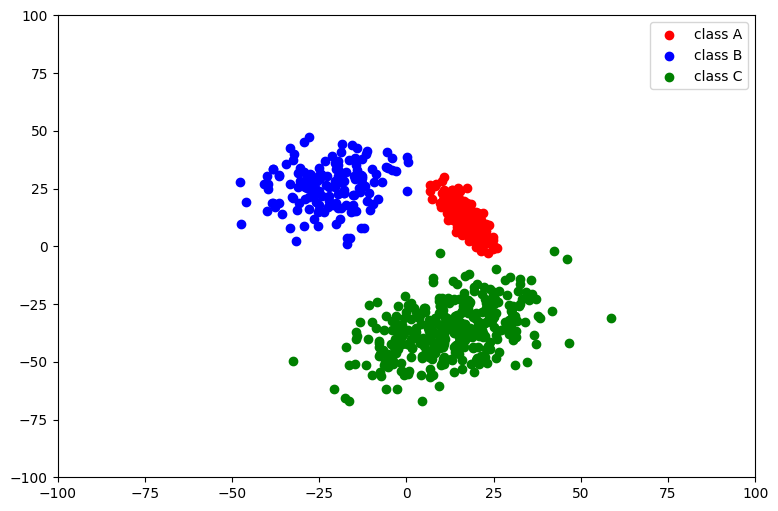

In [35]:
plt.figure(figsize=(9, 6))
plt.scatter(A[:, 0], A[:, 1], color='r', label='class A')
plt.scatter(B[:, 0], B[:, 1], color='b', label='class B')
plt.scatter(C[:, 0], C[:, 1], color='g', label='class C')
plt.legend()
plt.xlim(-100, 100)
plt.ylim(-100, 100)
plt.show()

In [36]:
data = torch.cat([A, B, C])

In [37]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto").fit(data)

In [38]:
torch.tensor(kmeans.cluster_centers_)

tensor([[ 11.9936, -36.8721],
        [ 17.0215,  12.0315],
        [-22.2852,  26.0058]], dtype=torch.float64)

In [39]:
N_ITERS = 100
LR = 3e-2

model = DeepClustering(3, 2, 2, 14, cluster_centers_init=torch.tensor(kmeans.cluster_centers_))
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)


In [40]:
def train(model, data, optimizer, epochs):
    avg_loss = .0
    losses = []
    pbar = trange(epochs)
    for epoch in pbar:
        model.train()
        optimizer.zero_grad()
        #q = model(data)
        #print(q)
        loss = model.compute_loss(data)["clustering_loss"]
        losses.append(loss.item())
        pbar.set_description(f"Loss: {loss.item():.2f}")
        loss.backward()
        optimizer.step()
    return losses

In [41]:
train(model, data, optimizer, N_ITERS)

  0%|          | 0/100 [00:00<?, ?it/s]

[2.0598547761122306,
 2.0574081150583052,
 2.052806703708825,
 2.046353185203751,
 2.0383538748244097,
 2.0291134455049975,
 2.0189304488346322,
 2.0080930599124893,
 1.9968746873820877,
 1.9855293240680063,
 1.9742867363255232,
 1.963347789816922,
 1.9528803592619082,
 1.9430163372214018,
 1.9338502170111012,
 1.9254395731593104,
 1.9178075240131878,
 1.9109469860080182,
 1.9048262811726469,
 1.8993954948402245,
 1.894592930755342,
 1.8903510748785082,
 1.8866016281998699,
 1.8832793588081107,
 1.8803247105113954,
 1.8776852571608962,
 1.8753161923782518,
 1.8731800924357,
 1.8712461945014929,
 1.869489406851921,
 1.867889225624221,
 1.8664286854124295,
 1.865093426189158,
 1.86387092104538,
 1.8627498798382411,
 1.8617198230248453,
 1.8607708067323363,
 1.8598932730236128,
 1.859077996836774,
 1.858316101807367,
 1.8575991199526736,
 1.856919074083784,
 1.8562685661304648,
 1.8556408588381694,
 1.8550299422212677,
 1.8544305795565599,
 1.8538383305030486,
 1.853249551131295,
 1.85266

In [42]:
model.centers

Parameter containing:
tensor([[ 12.0978, -35.8852],
        [ 18.2974,  11.9221],
        [-21.9358,  26.6118]], dtype=torch.float64, requires_grad=True)

In [43]:
torch.tensor(kmeans.cluster_centers_)

tensor([[ 11.9936, -36.8721],
        [ 17.0215,  12.0315],
        [-22.2852,  26.0058]], dtype=torch.float64)

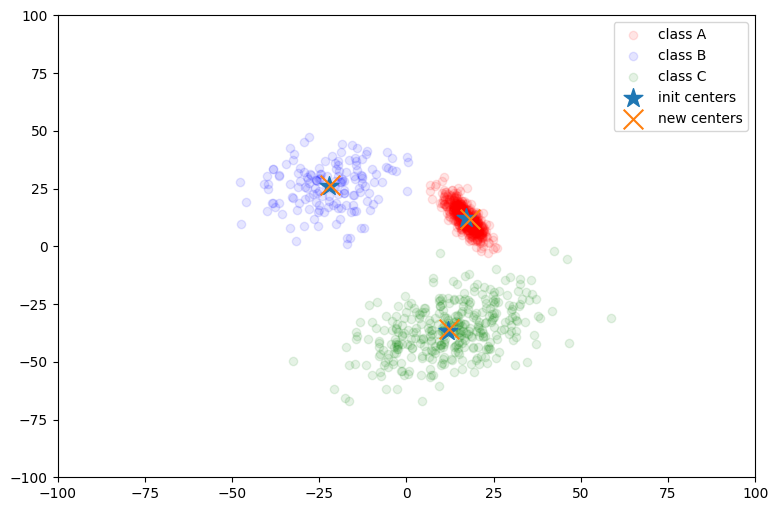

In [57]:
new_centers = model.centers.detach().numpy()

plt.figure(figsize=(9, 6))
plt.scatter(A[:, 0], A[:, 1], color='r', alpha=0.1, label='class A')
plt.scatter(B[:, 0], B[:, 1], color='b', alpha=0.1, label='class B')
plt.scatter(C[:, 0], C[:, 1], color='g', alpha=0.1, label='class C')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='*', label='init centers', s=200)
plt.scatter(new_centers[:, 0], new_centers[:, 1], marker='x', label='new centers', s=200)
plt.legend()
plt.xlim(-100, 100)
plt.ylim(-100, 100)
plt.show()